In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
from os import path
from glob import glob
import numpy as np
import matplotlib.pylab as plt

from se3cnn.point_utils import difference_matrix
from pao_file_utils import parse_pao_file, write_pao_file
from pao_tfn_dataset import encode_kind
from pao_tfn_trainer import train_pao_tfn, loss_function
from cp2k_file_utils import read_energy

In [4]:
# Load training data and hard code metadata.
pao_files = sorted(glob("2H2O_MD/frame_*/2H2O_pao44-1_0.pao"))

prim_basis_shells = {
    'H': [2, 1, 0], # two s-shells, one p-shell, no d-shells
    'O': [2, 2, 1], # two s-shells, two p-shells, one d-shell
}

pao_basis_size = 4

In [5]:
# Use the first few frames to train networks for Hydrogen and Oxygen.
num_training_frames = 2
max_epochs = 500
num_hidden = 1

training_pao_files = pao_files[:num_training_frames]
net_H = train_pao_tfn(training_pao_files, prim_basis_shells, pao_basis_size, kind_name="H", num_hidden=num_hidden, max_epochs=max_epochs)
net_O = train_pao_tfn(training_pao_files, prim_basis_shells, pao_basis_size, kind_name="O", num_hidden=num_hidden, max_epochs=max_epochs)

Training NN for kind H using 8 samples.
Epoch: 0  Loss: 0.199871
Epoch: 20  Loss: 0.0580129
Epoch: 40  Loss: 0.0253284
Epoch: 60  Loss: 0.0146206
Epoch: 80  Loss: 0.00793892
Epoch: 100  Loss: 0.00103611
Epoch: 120  Loss: 0.000512239
Epoch: 140  Loss: 0.000243408
Epoch: 160  Loss: 0.000219906
Epoch: 180  Loss: 0.000140412
Epoch: 200  Loss: 0.000128865
Epoch: 220  Loss: 8.31134e-05
Epoch: 240  Loss: 9.33294e-05
Epoch: 260  Loss: 0.000102191
Epoch: 280  Loss: 7.05943e-05
Epoch: 300  Loss: 5.18908e-05
Epoch: 320  Loss: 2.85734e-05
Epoch: 340  Loss: 2.06318e-05
Epoch: 360  Loss: 2.05084e-05
Epoch: 380  Loss: 1.55753e-05
Epoch: 400  Loss: 4.02678e-05
Epoch: 420  Loss: 7.09238e-05
Epoch: 440  Loss: 2.51025e-05
Epoch: 460  Loss: 5.83547e-05
Epoch: 480  Loss: 3.22602e-05
Training NN for kind O using 4 samples.
Epoch: 0  Loss: 0.0769185
Epoch: 20  Loss: 0.0407118
Epoch: 40  Loss: 0.0203366
Epoch: 60  Loss: 0.00721298
Epoch: 80  Loss: 0.000717717
Epoch: 100  Loss: 0.000157313
Epoch: 120  Loss: 7.

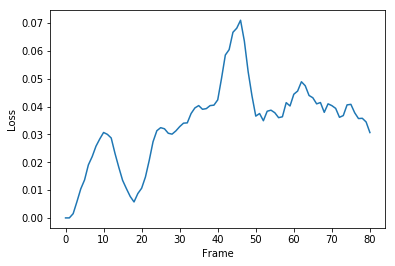

In [6]:
# Use the trained networks to inferre xblocks for all frames and calc their loss.
xblocks_inferred = []
losses = []

for fn in pao_files:
    kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
    kind_onehot = encode_kind(atom2kind)
    natoms = coords.shape[0]
    losses.append(0.0)
    xblocks_inferred.append([])
    for iatom in range(natoms):
        rolled_kinds = np.roll(kind_onehot, shift=-iatom, axis=1)
        rolled_coords =  np.roll(coords, shift=-iatom, axis=0)
        rolled_kinds_torch = torch.from_numpy(rolled_kinds[None,...])
        rolled_coords_torch = torch.from_numpy(rolled_coords[None,...])
        diff_M = difference_matrix(rolled_coords_torch)
        if atom2kind[iatom] == "H":
            output_net = net_H(rolled_kinds_torch, diff_M)
            xblock_net = net_H.decode_xblock(output_net[0,:,0])
        elif atom2kind[iatom] == "O":
            output_net = net_O(rolled_kinds_torch, diff_M)
            xblock_net = net_O.decode_xblock(output_net[0,:,0])
        xblocks_inferred[-1].append(xblock_net.detach().numpy())
        loss = loss_function(xblock_net, torch.from_numpy(xblocks[iatom])) / natoms
        losses[-1] += loss.item()

plt.xlabel("Frame")
plt.ylabel("Loss")
plt.plot(losses);

In [7]:
# Run CP2K on a few of the inferred frames. DFT Energy difference below 1 milliHartree would be nice.
verify_frames = (0, 1, 2, 3, 4, 10, 20)

for iframe, fn in enumerate(pao_files):
    if iframe not in verify_frames:
        continue
    print("Working on: "+fn)
    kinds, atom2kind, coords, xblocks = parse_pao_file(fn)
    frame_dir = path.dirname(fn)
    fn_inferred = frame_dir + "/inferred.pao"
    write_pao_file(fn_inferred, kinds, atom2kind, coords, xblocks_inferred[iframe])
    ! cd $frame_dir; /opt/cp2k/exe/local/cp2k.ssmp -i 2H2O_pao44_inferred.inp > 2H2O_pao44_inferred.out
    pao_energy = read_energy(frame_dir+"/2H2O_pao44.out")
    pao_ml_energy = read_energy(frame_dir+"/2H2O_pao44_inferred.out")
    print("Loss: {:g} Energy-diff: {:g} Hartree\n".format(losses[iframe], pao_ml_energy - pao_energy))

Working on: 2H2O_MD/frame_0000/2H2O_pao44-1_0.pao
Loss: 5.10554e-06 Energy-diff: 7.28263e-05 Hartree

Working on: 2H2O_MD/frame_0025/2H2O_pao44-1_0.pao
Loss: 8.89534e-06 Energy-diff: 7.73257e-05 Hartree

Working on: 2H2O_MD/frame_0050/2H2O_pao44-1_0.pao
Loss: 0.00152929 Energy-diff: 0.00194181 Hartree

Working on: 2H2O_MD/frame_0075/2H2O_pao44-1_0.pao
Loss: 0.00585866 Energy-diff: 0.00594532 Hartree

Working on: 2H2O_MD/frame_0100/2H2O_pao44-1_0.pao
Loss: 0.0104333 Energy-diff: 0.0102591 Hartree

Working on: 2H2O_MD/frame_0250/2H2O_pao44-1_0.pao
Loss: 0.0307013 Energy-diff: 0.06961 Hartree

Working on: 2H2O_MD/frame_0500/2H2O_pao44-1_0.pao
Loss: 0.0106711 Energy-diff: 0.0195768 Hartree

